# Final Project


## Introduction
In this analysis, we investigated **the potential causal relationship between a baseball player's barrel rate and their rate of home runs** using statistics from the 2024 MLB season. Specifically, we analyzed the relationship between the proportion of barrels, batted balls that are at least 98 mph and have an optimal launch angle, and the rate of home runs per plate appearance. Barrels are seen as ideal hits that are more likely to result in extra-base hits (doubles, triples & home runs).

A potential confounder we identified is adjusted exit velocity. Adjusted exit velocity is calculated as the average of the maximum of 88 and the exit velocity of each bat (**average(max(88, Exit Velocity))**). It essentially summarizes how often and how powerfully a player bats. Our dataset contains statistics from 129 top players, collected by Statcast during the 2024 MLB season.

## Causal Model

**Variables**
*   B: Barrel Rate
*   H: HR Rate
*   EV: Adjusted Exit Velocity


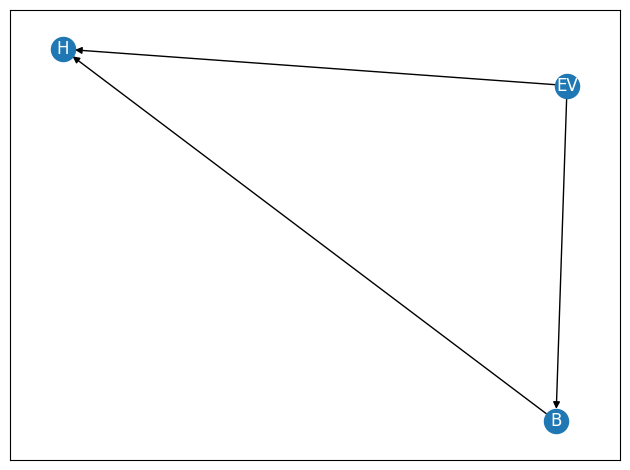

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
graph = nx.DiGraph()
graph.add_edges_from([("B", "H"), ("EV","H"), ("EV","B")])
nx.draw_networkx(graph, arrows=True, font_color="white")
plt.tight_layout()

### Description of Causal Model

The DAG above shows the assumed causal relationships. A high barrel rate is expected to increase the home run rate as barrels are ideal hits with high speed and optimal angles for home runs. Adjusted exit velocity, a measure of a player's batting power, may result in an increase in home run rate both directly and indirectly. It contributes to a higher barrel rate and also independently increases the likelihood of a home run, even if the hit doesn’t meet the criteria for a barrel.

## Statistical Model

### Data Preprocessing

In [ ]:
import pandas as pd
from scipy.special import expit as logistic
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

In [ ]:
import pandas as pd
df = pd.read_csv('stats.csv')
df

,"last_name, first_name",player_id,year,pa,home_run,barrel_batted_rate,avg_hyper_speed
0,"Chisholm Jr., Jazz",665862,2024,621,24,9.7,94.459142
1,"Rooker Jr., Brent",667670,2024,614,39,16.6,96.193453
2,"Freeman, Freddie",518692,2024,638,22,9.1,94.527301
3,"Gurriel Jr., Lourdes",666971,2024,553,18,6.7,93.921850
4,"Santander, Anthony",623993,2024,665,44,11.7,94.357157
...,...,...,...,...,...,...,...
124,"France, Ty",664034,2024,535,13,7.3,94.004651
125,"Cruz, Oneil",665833,2024,599,21,15.7,98.547881
126,"Altuve, Jose",514888,2024,682,20,6.5,92.693763
127,"Keith, Colt",690993,2024,556,13,5.6,93.330372


In [ ]:
# add home run rate
#df['hr_rate'] = df.home_run/df.pa

# convert barrel rate to a proportion
#df['barrel_rate'] = df.barrel_batted_rate/100

# rename for clarity
#df['adjusted_ev'] = df.avg_hyper_speed

# select columns
df = df[['last_name, first_name', 'player_id', 'barrel_rate', 'adjusted_ev', 'hr_rate']]
df = df.sort_values(by='barrel_rate', ascending=False)
df

,"last_name, first_name",player_id,barrel_rate,adjusted_ev,hr_rate
48,"Judge, Aaron",592450,0.269,99.103702,0.082386
8,"Ohtani, Shohei",660271,0.215,98.772122,0.073871
115,"Soto, Juan",665742,0.197,97.994705,0.057504
1,"Rooker Jr., Brent",667670,0.166,96.193453,0.063518
125,"Cruz, Oneil",665833,0.157,98.547881,0.035058
...,...,...,...,...,...
121,"Turang, Brice",668930,0.024,92.521822,0.011309
85,"Arraez, Luis",650333,0.016,91.449624,0.005952
76,"Young, Jacob",696285,0.016,92.486925,0.005758
59,"Hoerner, Nico",663538,0.012,91.993966,0.010920


In [ ]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

B = standardize(df.barrel_rate)
EV = standardize(df.adjusted_ev)

### Priors

The priors are chosen based on a combination of data outside of the dataset and the prior predictive simulation. From prior research, I found that in 2023, teams had an average of 1.21 home runs and 37.88 plate appearances per game for a home run rate of 3.58% [(source)](https://www.baseball-reference.com/leagues/majors/bat.shtml).
Therefore, the intercept was set to -3.3 as logistic(-3.3) = 0.0356 to roughly match that value. As the treatment variable, barrel rate is standardized, the intercept represents the home run rate of a player with an average barrel rate. The slope, beta, was modeled with a log normal prior allowing only positive values. This is because the relationship between barrel rate and home run rate is believed to be positive. For adjusted velocity coefficient, as we don't know its actual direct relationship with home runs, we decide to use a normal distribution to allow larger range.

The outcome variable, home run rate is modeled with a logit normal distribution as it is a proportion which is thus between 0 and 1.

In [ ]:
from scipy.special import expit as logistic
logistic(-3.3)

np.float64(0.03557118927263618)

[0.49298346 0.2376463  0.35774185 0.21721716 0.29092849 0.30282461
 0.3789403  0.23635075 0.24968653 0.45151422]


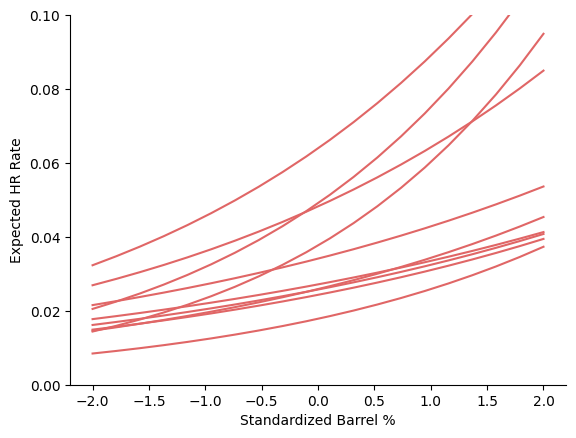

In [ ]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit as logistic

NUM_LINES = 10
x_seq = np.linspace(-2, 2, 20)

alpha = stats.norm.rvs(loc=-3.3, scale=.3, size=NUM_LINES)
beta = np.random.lognormal(mean=np.log(0.3), sigma=0.3, size=NUM_LINES)
print(beta)
for i in range(NUM_LINES):
    linear = alpha[i] + beta[i] * x_seq
    lambda_ = logistic(linear)
    _ = plt.plot(x_seq, lambda_, color="#e06666")

plt.ylim((0,.1))
plt.xlabel("Standardized Barrel %")
plt.ylabel("Expected HR Rate")
sns.despine();

A prior predictive simulation was performed to evaluate the priors. The intercept was modeled using a normal distribution, N(−3.3,0.3), representing a baseline home run rate when standardized barrel rate is 0. The slope, beta, was modeled using a log normal distribution with a mean of log(0.3) and standard deviation of 0.3 showing a positive relationship between standardized barrel rate and expected home run rate. For each sample, the linear predictor was transformed using the logistic function, producing expected home run rates with most between 1 and 10%. This supports the prior assumptions and aligns with domain knowledge about barrel and home run rates.

## Stastical Model


### Model Description

**Unadjusted Model**

The unadjusted model includes only barrel rate and home run rate, without adjusting for the confounding variable, adjusted exit velocity. This model estimates how changes in barrel rate alone may be associated with changes in home run rate.

Model: $\text{logit}(\mu) = \alpha + \beta_{\mathrm{barrel\_rate}}*\mathrm{barrel\_rate}$

* $Y \sim \text{Normal}(\mu, \sigma)$
* $\alpha \sim \text{Normal}(-3.3, 0.3)$
* $\beta_{\mathrm{barrel\_rate}} \sim \text{LogNormal}(\log(0.3),0.5)$
* $\sigma \sim \text{Exponential}(1.0)$


**Adjusted Model:**

**Handle of Confound Variables:** We find that there is a backdoor path: Barrel Rate <- Adjusted EV -> HR Rate in the DAG model. To estimate the direct effect of Barrel Rate on HR Rate, we need to close this backdoor path. As this is a fork structure, we can close this backdoor path by adjusting on the confound variable Adjusted EV.

Model: $\text{logit}(\mu) = \alpha + \beta_{\mathrm{barrel\_rate}}*\mathrm{barrel\_rate}+\beta_{\mathrm{adjusted\_ev}}*\mathrm{adjusted\_ev}$

- $Y \sim \text{Normal}(\mu, \sigma)$
- $\alpha \sim \text{Normal}(-3.3, 0.3)$
- $\beta_{\mathrm{barrel\_rate}} \sim \text{LogNormal}(\log(0.3),0.5)$
- $\beta_{\mathrm{adjusted\_ev}} \sim \text{Normal}(0.0,1.0)$
- $\sigma \sim \text{Exponential}(1.0)$









### Model Validation with Simulation

For simulation, we define a set of simulated parameter values. $\alpha = -3.340,\beta = 0.5,\beta_{\mathrm{barrel\_rate}}=0.45,\beta_{\mathrm{adjusted\_ev}}=-0.3$. Then we generate correspondent simulated data and then plot the posterior distribution of each parameters to see if our model can estimate these parameters well.

Output()

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>], dtype=object)

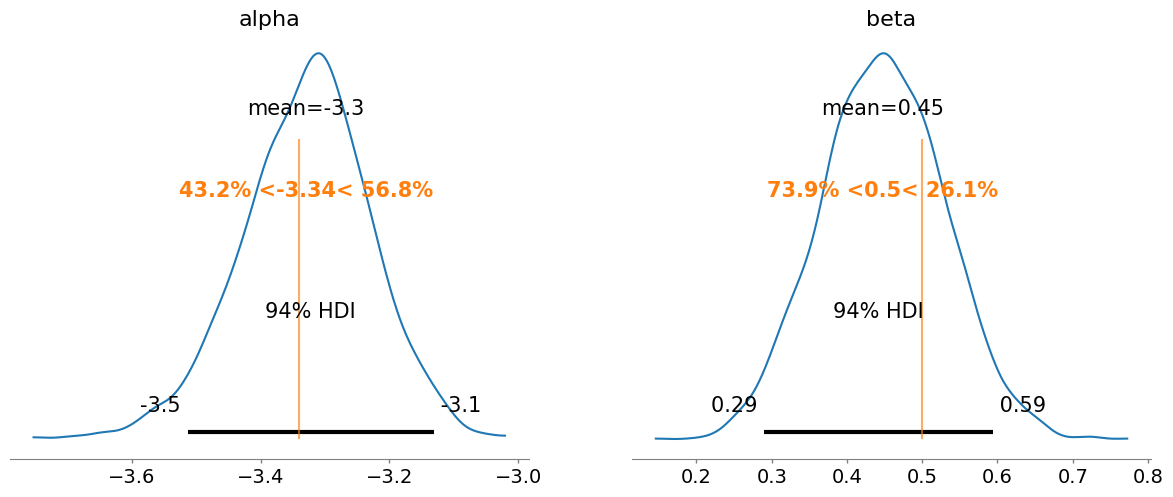

In [ ]:
# Simulation for Non-Adjust
# simulated parameters
sim_alpha = -3.340
sim_sigma = 0.1
sim_beta = 0.5
sim_size = 1000
# generate simulation data
sim_B_data = np.random.normal(0.0,1.0,sim_size)
sim_EV_data = np.random.normal(0.0,1.0,sim_size)

sim_mu_no_adjust = logistic(sim_alpha + sim_beta * sim_B_data)
sim_hr_rate_no_adjust = np.random.normal(sim_mu_no_adjust,sim_sigma,sim_size)


with pm.Model() as test_model_barrel:
    # priors
    a = pm.Normal("alpha", mu=-3.3, sigma=0.3)
    b = pm.LogNormal("beta", mu=np.log(0.3), sigma=0.5)

    sigma = pm.Exponential("sigma", 1.0)
    p = pm.Deterministic("p", pm.math.invlogit(a + b * sim_B_data))
    y = pm.Normal("y", mu=p, sigma=sigma, observed=sim_hr_rate_no_adjust)

    # sample
    idata_barrel_test = pm.sample(idata_kwargs={"log_likelihood": True}, chains=4)

az.plot_posterior(idata_barrel_test, var_names=["alpha", "beta"], ref_val=[sim_alpha, sim_beta])

Output()

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta_barrel'}>,
       <Axes: title={'center': 'beta_adjustEV'}>], dtype=object)

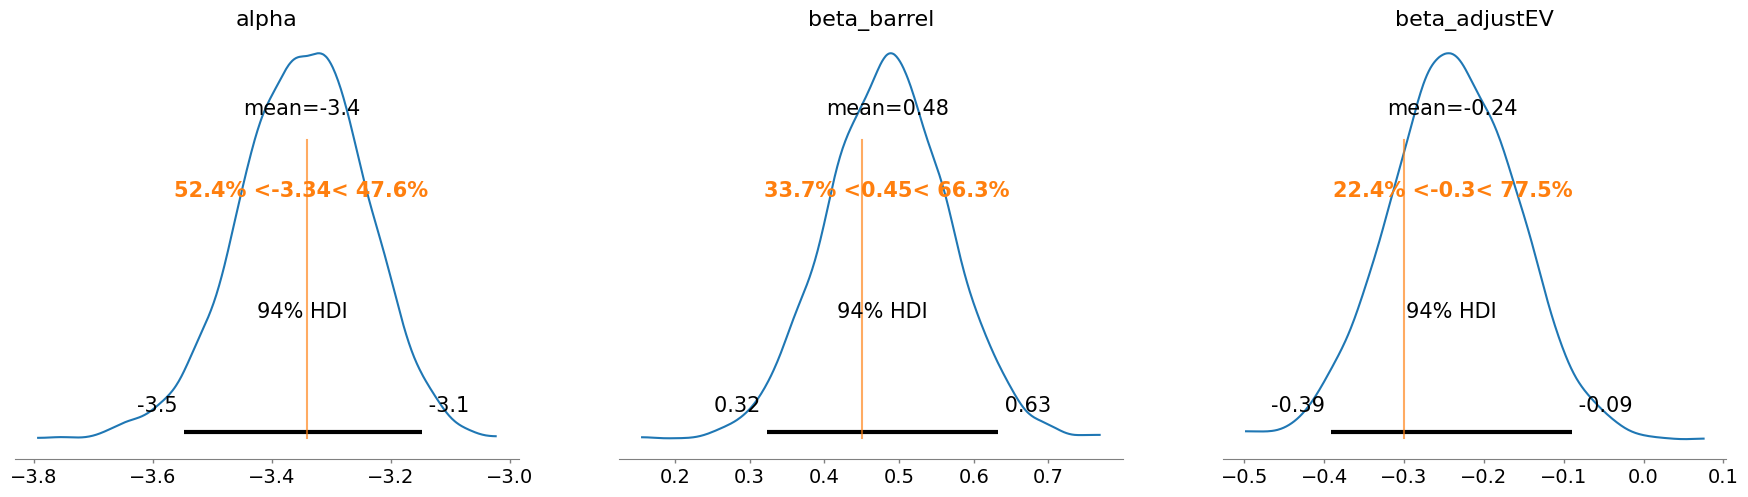

In [ ]:
# Simulation for Adjust
# simulated parameters
sim_alpha = -3.340
sim_beta_barrel = 0.45
sim_beta_adjustEV = -0.3
sim_sigma = 0.1
sim_size = 1000
# generate simulation data
sim_B_data = np.random.normal(0.0,1.0,sim_size)
sim_EV_data = np.random.normal(0.0,1.0,sim_size)

sim_mu_adjust = logistic(sim_alpha + sim_beta_barrel * sim_B_data + sim_beta_adjustEV * sim_EV_data)
sim_hr_rate_adjust = np.random.normal(sim_mu_adjust,sim_sigma,sim_size)

with pm.Model() as test_model_barrel_ev:
  # priors
  a = pm.Normal("alpha", mu=-3.3, sigma=0.3)
  b_barrel = pm.LogNormal("beta_barrel", mu=np.log(0.3), sigma=0.5)
  b_adjustEV = pm.Normal("beta_adjustEV", mu=0, sigma=1.0)

  sigma = pm.Exponential("sigma", 1.0)
  p = pm.Deterministic("p", pm.math.invlogit(a + b_barrel * sim_B_data + b_adjustEV * sim_EV_data))
  y = pm.Normal("y", mu=p, sigma=sigma, observed=sim_hr_rate_adjust)

  # sample
  idata_barrel_ev_test = pm.sample(idata_kwargs={"log_likelihood": True}, chains=4)
az.plot_posterior(idata_barrel_ev_test, var_names=["alpha", "beta_barrel", "beta_adjustEV"], ref_val=[sim_alpha, sim_beta_barrel, sim_beta_adjustEV])

It can be seen from the posterior parameter plot with reference values that both models can estimate the parameter well as the actual simulated value is located near the highest density area of the posterior distribution.

### Model on Real Data

In [ ]:
# unadjusted model
import pymc as pm
import arviz as az


with pm.Model() as barrel_model:
    # priors
    a = pm.Normal("alpha", mu=-3.3, sigma=0.3)
    b = pm.LogNormal("beta", mu=np.log(0.3), sigma=0.5)

    sigma = pm.Exponential("sigma", 1.0)
    p = pm.Deterministic("p", pm.math.invlogit(a + b * B))
    y = pm.Normal("y", mu=p, sigma=sigma, observed=df.hr_rate)

    # sample
    idata_barrel = pm.sample(idata_kwargs={"log_likelihood": True}, chains=4)

az.summary(idata_barrel, var_names=["alpha", "beta", "sigma"], kind="all")

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-3.343,0.021,-3.382,-3.305,0.0,0.0,3881.0,2895.0,1.0
beta,0.265,0.014,0.240,0.291,0.0,0.0,3555.0,3168.0,1.0
sigma,0.007,0.000,0.007,0.008,0.0,0.0,3991.0,3107.0,1.0


In [ ]:
# adjusted model

with pm.Model() as barrel_ev_model:
  # priors
  a = pm.Normal("alpha", mu=-3.3, sigma=0.3)
  b_barrel = pm.LogNormal("beta_barrel", mu=np.log(0.3), sigma=0.5)
  b_adjustEV = pm.Normal("beta_adjustEV", mu=0, sigma=1.0)

  sigma = pm.Exponential("sigma", 1.0)
  p = pm.Deterministic("p", pm.math.invlogit(a + b_barrel * B + b_adjustEV * EV))
  #y = pm.StudentT("y", nu=3, mu=p, sigma=sigma, observed=df.hr_rate)
  y = pm.Normal("y", mu=p, sigma=sigma, observed=df.hr_rate)

  # sample
  idata_barrel_ev = pm.sample(idata_kwargs={"log_likelihood": True}, chains=4)

az.summary(idata_barrel_ev, var_names=["alpha", "beta_barrel", "beta_adjustEV", "sigma"], kind="all")

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-3.342,0.021,-3.381,-3.303,0.000,0.000,2729.0,2145.0,1.0
beta_barrel,0.282,0.031,0.222,0.335,0.001,0.001,2109.0,2310.0,1.0
beta_adjustEV,-0.022,0.035,-0.086,0.045,0.001,0.001,2161.0,2124.0,1.0
sigma,0.007,0.000,0.007,0.008,0.000,0.000,2531.0,2428.0,1.0


## Posterior


First, we take a look at their sampling quality.

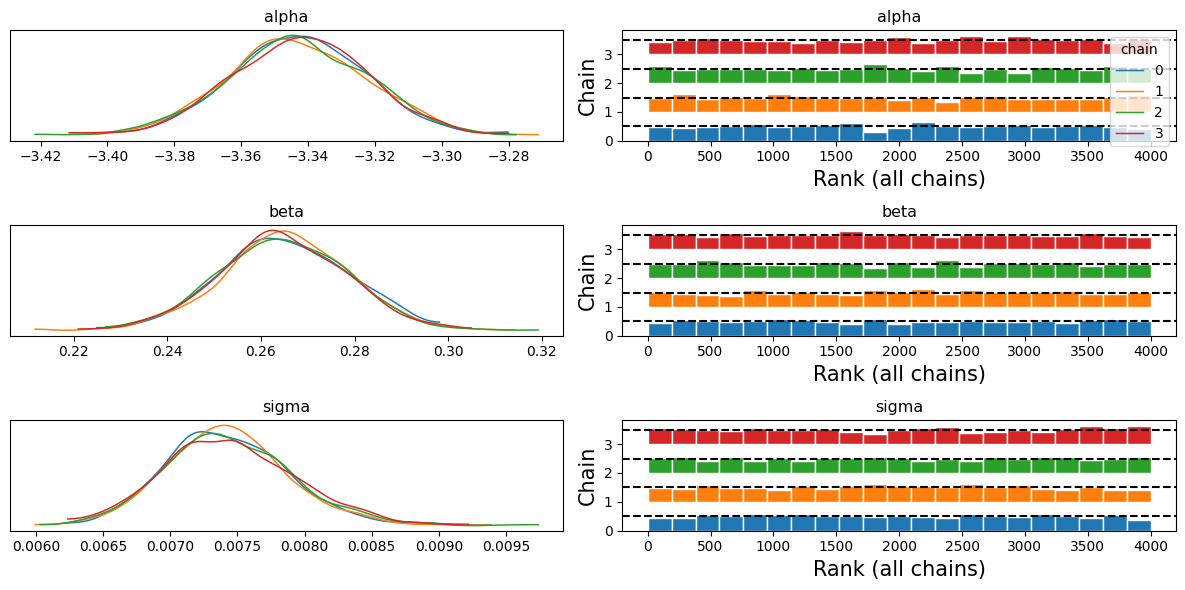

In [ ]:
with barrel_model:
    az.plot_trace(idata_barrel, legend=True, var_names=["alpha", "beta", "sigma"], compact=False, kind="rank_bars", divergences=None);
plt.tight_layout();

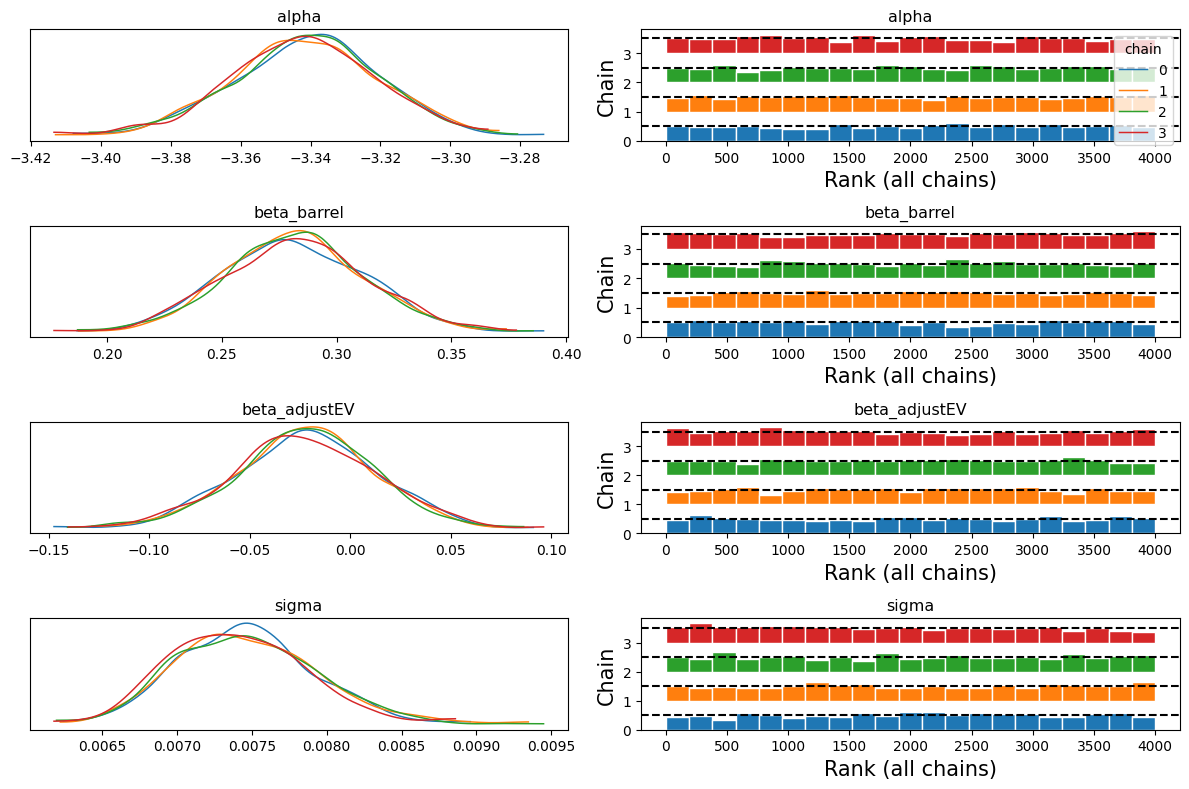

In [ ]:
with barrel_ev_model:
    az.plot_trace(idata_barrel_ev, legend=True, var_names=["alpha", "beta_barrel", "beta_adjustEV", "sigma"], compact=False, kind="rank_bars", divergences=None);
plt.tight_layout();

According to the built-in diagnostic tools, the sampling quality is satisfactory. Then we look at the other measurements provided by the summary table.

In [ ]:
#unadjusted model
az.summary(idata_barrel, var_names=["alpha", "beta", "sigma"], kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.0,0.0,3881.0,2895.0,1.0
beta,0.0,0.0,3555.0,3168.0,1.0
sigma,0.0,0.0,3991.0,3107.0,1.0


In [ ]:
#adjusted model
az.summary(idata_barrel_ev, var_names=["alpha", "beta_barrel", "beta_adjustEV", "sigma"], kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.000,2729.0,2145.0,1.0
beta_barrel,0.001,0.001,2109.0,2310.0,1.0
beta_adjustEV,0.001,0.001,2161.0,2124.0,1.0
sigma,0.000,0.000,2531.0,2428.0,1.0


You can see that for both models, mcse_mean and mcse_sd is near 0.0; ess_bulk and ess_tail are larger than 1000 and r_hat is near 1.0 which means that based on these built-in diagnostics variables, our model has a good sampling quality.

### Posterior Predictive Checks

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


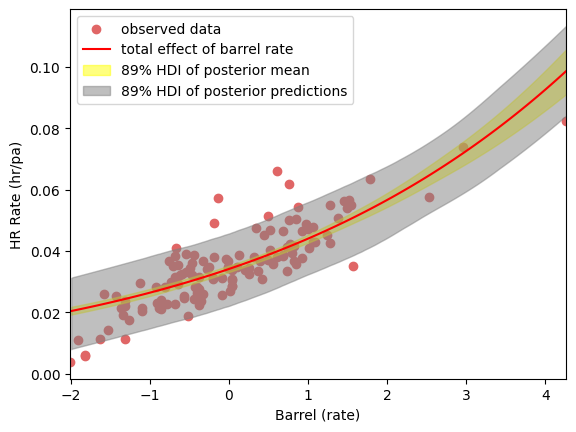

In [ ]:
import numpy as np
import arviz as az

#unadjsuted model
_ = plt.scatter(B, df['hr_rate'], color="#e06666", label='observed data')
_ = plt.xlabel("Barrel (rate)")

barrel_seq = np.linspace(B.min(), B.max(), 100)

idata_barrel_thinned = az.extract(idata_barrel, num_samples=1000)
mu_pred = np.zeros((len(barrel_seq), idata_barrel_thinned.sizes["sample"]))
a_values = idata_barrel_thinned.alpha.values
b_values = idata_barrel_thinned.beta.values
for i, bar in enumerate(barrel_seq):
  mu_pred[i] = logistic(a_values + b_values * (bar))
mu_mean = mu_pred.mean(1)

_ = plt.plot(barrel_seq, mu_mean, color='r', label='total effect of barrel rate')
ax = az.plot_hdi(barrel_seq, mu_pred.T, hdi_prob=0.89, color='yellow', fill_kwargs={"label": "89% HDI of posterior mean"})
_ = plt.xlabel("Barrel (rate)")
_ = plt.ylabel("HR Rate (hr/pa)")
plt.xlim(B.min(), B.max());

mu_pred_obs = np.zeros((len(B), idata_barrel_thinned.sizes["sample"]))
sigma_values = idata_barrel_thinned.sigma.values
hrrate_pred = np.zeros((len(B), idata_barrel_thinned.sizes["sample"]))
for i, bar in enumerate(B):
  mu_pred_obs[i] = logistic(a_values + b_values * (bar))
  hrrate_pred[i] = stats.norm.rvs(mu_pred_obs[i], sigma_values)
_ = az.plot_hdi(B, hrrate_pred.T, ax=ax, hdi_prob=0.89, color="gray", fill_kwargs={"label": "89% HDI of posterior predictions"})
_ = plt.xlabel("Barrel (rate)")
_ = plt.ylabel("HR Rate (hr/pa)")
plt.xlim(B.min(), B.max());
plt.legend()


/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


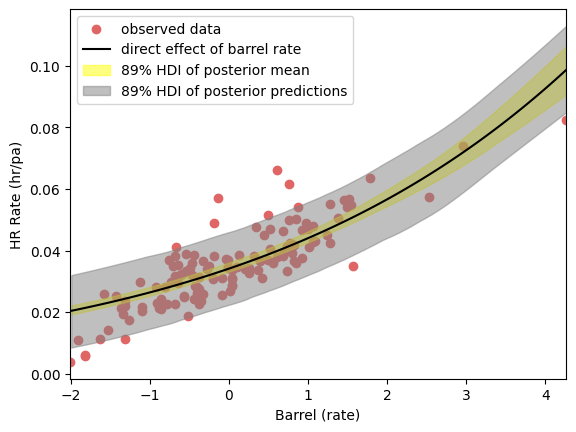

In [ ]:

#adjusted model
_ = plt.scatter(B, df['hr_rate'], color="#e06666", label='observed data')
_ = plt.xlabel("Barrel (rate)")

barrel_seq = np.linspace(B.min(), B.max(), 100)
ev_seq = np.linspace(EV.min(), EV.max(), 100)

idata_barrel_ev_thinned = az.extract(idata_barrel_ev, num_samples=1000)
mu_pred_confound = np.zeros((len(barrel_seq), idata_barrel_ev_thinned.sizes["sample"]))
a_adjusted_values = idata_barrel_ev_thinned.alpha.values
b_barrel_values = idata_barrel_ev_thinned.beta_barrel.values
b_adjustEV_values = idata_barrel_ev_thinned.beta_adjustEV.values
for i, bar in enumerate(barrel_seq):
  mu_pred_confound[i] = logistic(a_adjusted_values + b_barrel_values * bar + b_adjustEV_values * ev_seq[i])
mu_mean_confound = mu_pred.mean(1)

_2 = plt.plot(barrel_seq, mu_mean_confound, color='k', label='direct effect of barrel rate')
ax = az.plot_hdi(barrel_seq, mu_pred_confound.T, hdi_prob=0.89, color='yellow', fill_kwargs={"label": "89% HDI of posterior mean"})
_2 = plt.xlabel("Barrel (rate)")
_2 = plt.ylabel("HR Rate (hr/pa)")
plt.xlim(B.min(), B.max());

mu_pred_confound_obs = np.zeros((len(B), idata_barrel_ev_thinned.sizes["sample"]))
sigma_adjusted_values = idata_barrel_ev_thinned.sigma.values
hrrate_confound_pred = np.zeros((len(B), idata_barrel_ev_thinned.sizes["sample"]))
for i, bar in enumerate(B):
  mu_pred_confound_obs[i] = logistic(a_adjusted_values + b_barrel_values * bar + b_adjustEV_values * EV[i])
  hrrate_confound_pred[i] = stats.norm.rvs(mu_pred_confound_obs[i], sigma_values)
_2 = az.plot_hdi(B, hrrate_confound_pred.T, ax=ax, hdi_prob=0.89, color="gray", fill_kwargs={"label": "89% HDI of posterior predictions"})
_2 = plt.xlabel("Barrel (rate)")
_2 = plt.ylabel("HR Rate (hr/pa)")
plt.xlim(B.min(), B.max());

plt.legend()

### Discussion of the results of the posterior predictive check

Our model seems to fit the observed data fairly well. To the naked eye, our curve runs through a majority of the observed data and follows its shape quite nicely. This observation is reinforced when comparing the shape of our modeled curve and posterior mean HDI to the posterior predictions' HDI. Again, the fit here is very close. That said, the predictions' HDI is significantly wider than the mean's HDI. In effect, our mean HDI is very thin around the curve, relatively speaking which indicates a high level of confidence in its ability to fit the observed data. The difference in width between the two HDI's indicates a large variance, which points to the influence of the outliers. These are generally skewed towards the higher end of the curve, as it tends to be in a sports context.

We also find that our curve has an increasing exponential shape, meaning small increases in barrel rate lead to larger increases in HR rate.

### **What we learned**

We learned that barrel rate does have a positive effect on the Home Run rate of a given batter. That is, the more appropriate the general exit velocity and launch angles of their hits, the more home runs they will hit. This seems fairly intuitive; a ball hit hard enough and at a high enough angle should result in a home run. Interestingly, however, exit velocity seems to bear a negative effect (if at all) on Home Run rate when taken as a confound alongside barrel rate. This seems less intuitive and is perhaps the biggest learning from our statistical analysis. It would be interesting to study why that is in a separate model. One explanation for this could be that, after a certain point, exit velocity no longer matters. There's only a certain velocity the ball needs to reach in order to exit the diamond and anything beyond that no longer matters. This is not true for launch angle, the other part of barrel rate, for which a too large angle could result in a pop fly. It could also be the case that exit velocity on its own simply doesn't bear any influence on HR rate. A ball hit at blinding speeds but at a low angle will almost surely not result in a home run after all. In the future, one might try to model the direct effect of exit velocity on home rune rate, isolating confounds such as bat speed for example.

## Future Discussion

Speaking of future modeling, it could be interesting to try finding models that could better account for the outliers in this dataset. As we previously discussed, though our model does a great job of fitting the observed data, it struggles to account for outliers. We could try to use a quadratic model or even a cubic one and see if it fits our observed data even better. At a glance, there do seem to be some inflection points in the scatter plot we could account for.

Another interesting exercise could be to analyze the predictive ability of our models. A brief check tells us that our models actually do a pretty good job when it comes to prediction (only one potentially unreliable prediction). This has various applications, particularly when it comes to analytics and predicting match outcomes.

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


                    rank    elpd_loo     p_loo  elpd_diff        weight  \
m_linear_barrel        0 -893.348479  5.602436   0.000000  1.000000e+00   
m_linear_barrel_ev     1 -890.708280  7.284899   2.640199  4.440892e-16   

                           se       dse  warning     scale  
m_linear_barrel     22.673904  0.000000     True  deviance  
m_linear_barrel_ev  23.048703  1.889047     True  deviance  


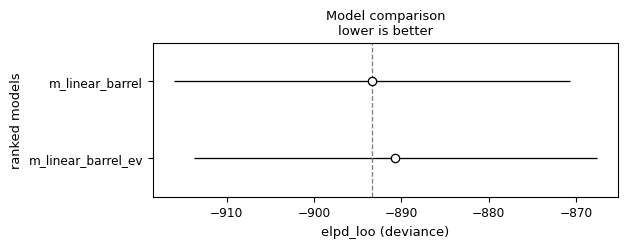

In [ ]:
model_dict = {
    "m_linear_barrel": idata_barrel,
    "m_linear_barrel_ev": idata_barrel_ev
}
compare_df_psis = az.compare(
    compare_dict=model_dict,
    ic="loo",
    scale="deviance"
)
print(compare_df_psis)
_ = az.plot_compare(compare_df_psis)

In [ ]:
psis_df = pd.DataFrame({
    "psis_barrel": az.loo(idata_barrel, pointwise=True, scale="deviance").pareto_k,
    "psis_barrel_ev": az.loo(idata_barrel_ev, pointwise=True, scale="deviance").pareto_k
})

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [ ]:
outliers_barrel = psis_df[(psis_df["psis_barrel"] >= 0.7)]
print(outliers_barrel)

outliers_barrel_ev = psis_df[(psis_df["psis_barrel_ev"] >= 0.7)]
print(outliers_barrel_ev)

    psis_barrel  psis_barrel_ev
55     0.850255        1.062946
    psis_barrel  psis_barrel_ev
55     0.850255        1.062946
